# Oracle-Reto 2: Análisis de sentimiento

*NUWE EVA*, la cadena de restauración fast food y healthy, sigue creciendo y queremos dar un paso más para mejorar y ofrecer el mejor servicio posible a nuestros clientes.

Queremos evolucionar y ofrecer nuevas capacidades a nuestro robot y talentoso camarero, *EVA*, añadiendo la función de poder detectar, a través de frases y palabras utilizadas por los comensales, el grado de satisfacción de los platos probados y así ver qué platos y productos han gustado más o menos a los clientes.

Nuestro robot ya sabe detectar lo que pedirán los comensales según los productos elegidos. Ahora queremos saber cuál es el feedback de cada cliente para detectar si le ha gustado o no el plato servido.

> Objetivo
Crea un modelo predictivo de **clasificación** para poder **ordenar y o catalogar las reseñas**. Primero entrena tu modelo con las reseñas de entrenamiento. Una vez tengas el modelo que maximice la puntuación F1 (macro.), utiliza las reseñas de prueba como entrada para tu modelo.

In [1]:
from numpy import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./Data/train.csv',index_col = [0])
test = pd.read_csv('./Data/test.csv',index_col = [0])

In [3]:
train.head()

,text,label,label_text
train_idx,,,
0,i really do recommend this to anyone in need o...,1,positive
1,very good every day camera fits nicely in the ...,1,positive
2,"but , dollar for dollar , this dvd player is p...",1,positive
3,i got this phone yesterday and didn ' t find a...,1,positive
4,1 ) price gb of storage,1,positive


In [4]:
test.head()

,text
test_idx,
0,fm receiver it has none
1,"the picture quality surprised me , when i firs..."
2,great video clip quality for a digital camera ...
3,creative did well on its rechargeable battery ...
4,i highly recommend this camera to anyone looki...


In [5]:
''' shape '''
print(f'shape de los datos train {train.shape}')
print(f'shape de los datos test {test.shape}')

shape de los datos train (3016, 3)
shape de los datos test (754, 1)


In [8]:
train.label.value_counts()

1    1926
0    1090
Name: label, dtype: int64

In [9]:
train.label_text.value_counts()

positive    1926
negative    1090
Name: label_text, dtype: int64

In [10]:
# import natural language tool kit
import nltk as nlp
# import regex
import re

def tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte t0do el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

In [11]:
train['tokenized'] = train['text'].apply(lambda x: tokenizar(x))
train[['text', 'tokenized']].head()

,text,tokenized
train_idx,,
0,i really do recommend this to anyone in need o...,"[really, do, recommend, this, to, anyone, in, ..."
1,very good every day camera fits nicely in the ...,"[very, good, every, day, camera, fits, nicely,..."
2,"but , dollar for dollar , this dvd player is p...","[but, dollar, for, dollar, this, dvd, player, ..."
3,i got this phone yesterday and didn ' t find a...,"[got, this, phone, yesterday, and, didn, find,..."
4,1 ) price gb of storage,"[price, gb, of, storage]"


In [1]:
train = train.explode('tokenized')
train.drop(['label_text'], inplace=True)
train.shape

NameError: name 'train' is not defined

In [13]:
# Mean length and std of the reviews
train.groupby(['train_idx'])['tokenized'].count().describe()

count    3016.000000
mean       16.096154
std         9.415842
min         1.000000
25%         9.000000
50%        14.000000
75%        21.000000
max        72.000000
Name: tokenized, dtype: float64

In [26]:
# most used words in the reviews
train['tokenized'].value_counts(ascending=False)

the          3212
and          1518
it           1335
to           1328
is           1193
             ... 
substance       1
earned          1
shelf           1
distorts        1
handful         1
Name: tokenized, Length: 4554, dtype: int64

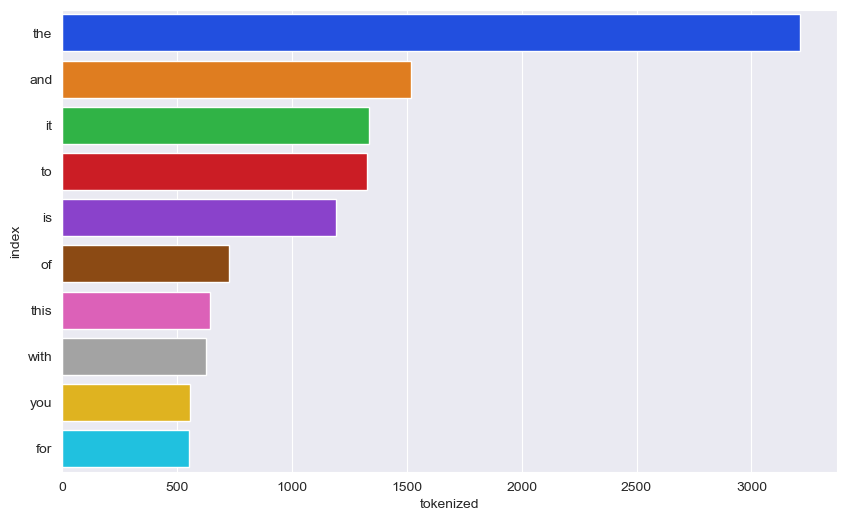

In [37]:
# Top 10 words
plt.figure(figsize=(10, 6))
counts  = train['tokenized'].value_counts(ascending=False).reset_index().head(10)
sns.barplot(data = counts, y = 'index', x = 'tokenized', orient= 'h', palette= 'bright')
plt.show()

# Stop words

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Ha estas palabras se les conoce como stopwords. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el término amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un análisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [38]:
from nltk.corpus import stopwords
# Obtain list of stopwords
stop_words = list(stopwords.words('english'))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [39]:
# filtering stopwords
train = train[~(train["tokenized"].isin(stop_words))]

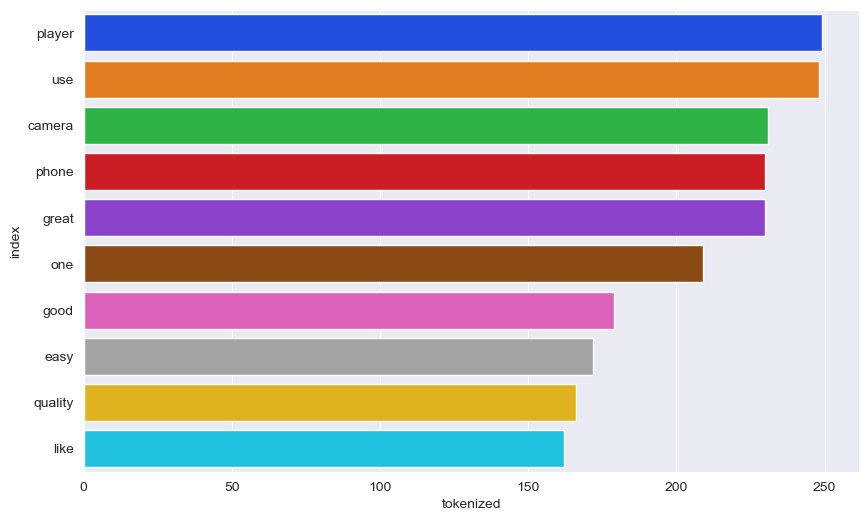

In [41]:
# Top 10 words without stopwords
plt.figure(figsize=(10, 6))
counts  = train['tokenized'].value_counts(ascending=False).reset_index().head(10)
sns.barplot(data = counts, y = 'index', x = 'tokenized', orient= 'h', palette= 'bright')
plt.show()

In [44]:
# term-frecuency (tf)
# ==============================================================================
tf = train.copy()
# Number of times a term appear in a review
tf = tf.groupby(["train_idx", "tokenized"])["tokenized"].agg(["count"]).reset_index()
# Se añade una columna con el total de términos por tweet
tf['total_count'] = tf.groupby('train_idx')['count'].transform(sum)
# Se calcula el tf
tf['tf'] = tf["count"] / tf["total_count"]
tf.sort_values(by = "tf").head(10)

,train_idx,tokenized,count,total_count,tf
2820,345,high,1,48,0.020833
2828,345,loss,1,48,0.020833
2829,345,low,1,48,0.020833
2830,345,manual,1,48,0.020833
2831,345,noise,1,48,0.020833
2832,345,peoples,1,48,0.020833
2833,345,perfect,1,48,0.020833
2827,345,longer,1,48,0.020833
2834,345,playback,1,48,0.020833
2836,345,protection,1,48,0.020833


In [53]:
# Inverse document frequency
# ==============================================================================
idf = train.copy()
total_documents = idf.reset_index()["train_idx"].drop_duplicates().count()
# Number of reviews for every term
# Número de documentos (tweets) en los que aparece cada término
idf = idf.groupby(["tokenized", "train_idx"])["tokenized"].agg(["count"]).reset_index()
idf['n_documentos'] = idf.groupby('tokenized')['count'].transform(sum)
# Cálculo del idf
idf['idf'] = log(total_documents / idf['n_documentos'])
idf = idf[["tokenized","n_documentos", "idf"]].drop_duplicates()
idf.sort_values(by="idf").head(3)

,tokenized,n_documentos,idf
15780,player,249,2.493902
22839,use,248,2.497926
2631,camera,231,2.568937


In [55]:
# Term Frequency - Inverse Document Frequency
# ==============================================================================
tf_idf = pd.merge(left=tf, right=idf, on="tokenized")
tf_idf["tf_idf"] = tf_idf["tf"] * tf_idf["idf"]
tf_idf.sort_values(by="train_idx").head()

,train_idx,tokenized,count,total_count,tf,n_documentos,idf,tf_idf
0,0,anyone,1,6,0.166667,16,5.238766,0.873128
347,0,really,1,6,0.166667,98,3.426388,0.571065
444,0,recommend,1,6,0.166667,36,4.427836,0.737973
116,0,player,1,6,0.166667,249,2.493902,0.415650
15,0,need,1,6,0.166667,53,4.041063,0.673511
